# Import Required Libraries

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


# Load and Explore Oil Price Data

In [2]:
# Load and Explore Oil Price Data
df = pd.read_csv("/content/drive/MyDrive/ML Work/NQ Project/oil_price.csv")
print(df.head())
print(df.info())


# === HANDLE MISSING DATA ===
print("Missing values per column before cleaning:")
print(df.isnull().sum())

# Drop rows where 'Price' is NaN (RECOMMENDED)
df = df.dropna(subset=['Price'])

print("Missing values after cleaning:")
print(df.isnull().sum())


           Date  Price
0  Jul 01, 2020  42.18
1  Jul 02, 2020  43.19
2  Jul 03, 2020  42.92
3  Jul 06, 2020  42.73
4  Jul 07, 2020  43.28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    635 non-null    object 
 1   Price   635 non-null    float64
dtypes: float64(1), object(1)
memory usage: 19.3+ KB
None
Missing values per column before cleaning:
Date     595
Price    595
dtype: int64
Missing values after cleaning:
Date     0
Price    0
dtype: int64


# Exploratory Data Analysis (EDA)

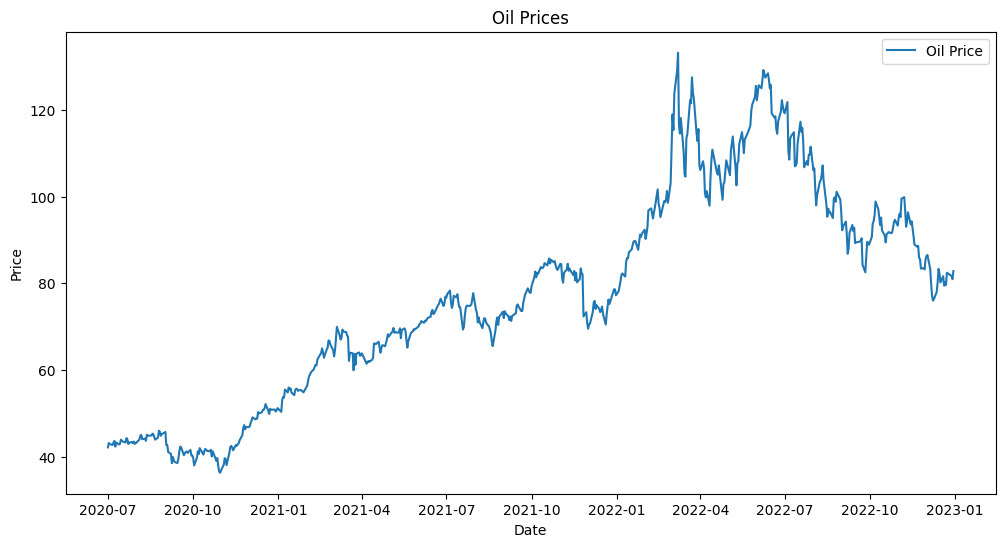

In [3]:
# Convert date column to datetime if needed
if "Date" in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

# Plot raw oil prices
plt.figure(figsize=(12,6))
plt.plot(df['Price'], label='Oil Price')
plt.title("Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Test for Stationarity

In [4]:
# Test for Stationarity (ADF and KPSS)
def test_stationarity(series):
    adf = adfuller(series, autolag='AIC')
    kpss_stat = kpss(series, regression='c', nlags="auto")
    print(f"ADF p-value: {adf[1]}")
    print(f"KPSS p-value: {kpss_stat[1]}")
    return adf[1], kpss_stat[1]

adf_p, kpss_p = test_stationarity(df['Price'])


ADF p-value: 0.48429238915100054
KPSS p-value: 0.01


# Make Data Stationary if Needed

In [5]:
# Differencing
diff_order = 0
series_stationary = df['Price'].copy()
while (adf_p > 0.05 or kpss_p < 0.05) and diff_order < 2:
    series_stationary = series_stationary.diff().dropna()
    diff_order += 1
    print(f"\nAfter differencing order {diff_order}:")
    adf_p, kpss_p = test_stationarity(series_stationary)



After differencing order 1:
ADF p-value: 6.0637563460194175e-06
KPSS p-value: 0.1


# ACF and PACF Plots

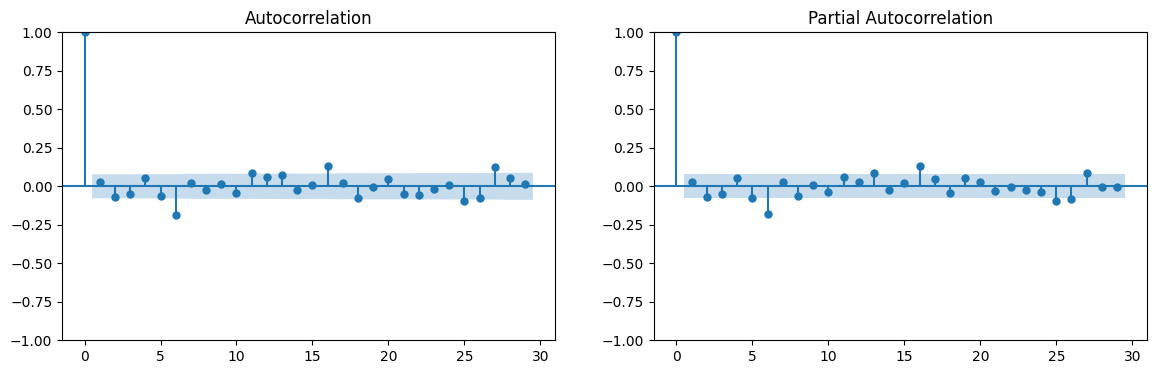

In [6]:
# Plot ACF and PACF
fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(series_stationary, ax=axes[0])
plot_pacf(series_stationary, ax=axes[1])
plt.show()


# ARMA/ARIMA Model Selection (Grid Search for Best p, d, q)

In [7]:
# Grid Search for Best ARMA/ARIMA Model (using AIC)
def grid_search_arma(series, max_p=8, max_d=2, max_q=8):
    best_aic = np.inf
    best_order = None
    best_model = None
    for d in range(0, max_d+1):
        temp_series = series.copy()
        for _ in range(d):
            temp_series = temp_series.diff().dropna()
        for p in range(0, max_p+1):
            for q in range(0, max_q+1):
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue
    print(f"Best ARMA/ARIMA Order: {best_order}, AIC: {best_aic}")
    return best_order, best_model

best_order, best_model = grid_search_arma(df['Price'], 8, 2, 8)


Best ARMA/ARIMA Order: (6, 1, 7), AIC: 2808.3818624022247


# Forecast 24 Months into the Future

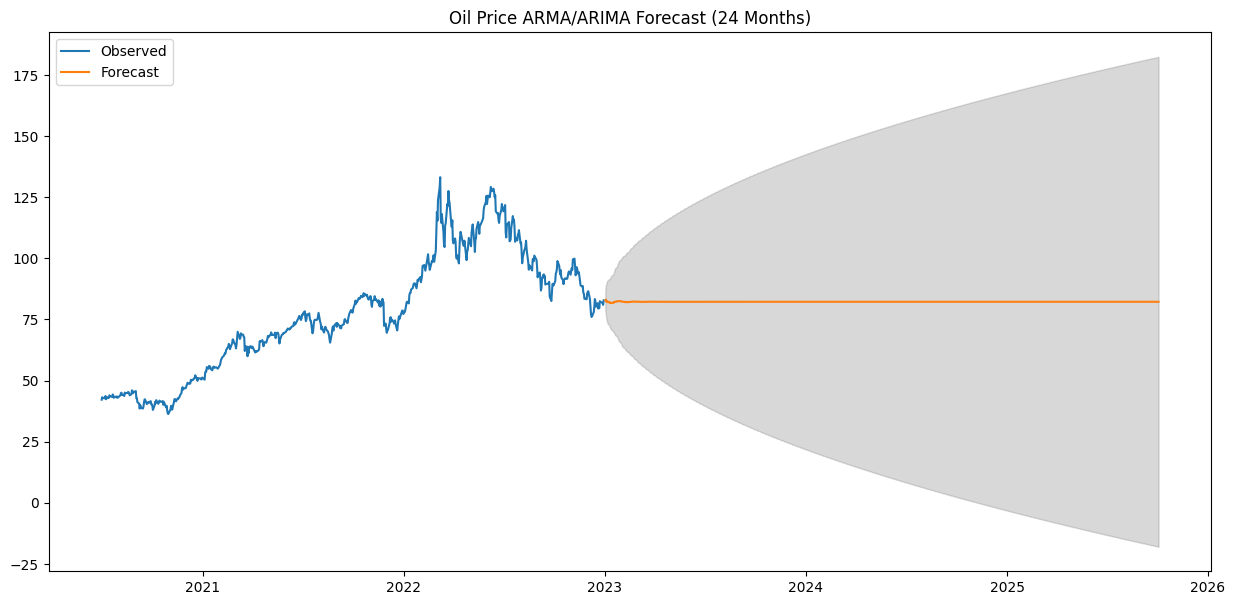

In [8]:
# Forecast 24 Months into the Future
n_forecast = 24*30  # Approximate days in 24 months
forecast_res = best_model.get_forecast(steps=n_forecast)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='B')

plt.figure(figsize=(15,7))
plt.plot(df.index, df['Price'], label='Observed')
plt.plot(future_dates, forecast_mean, label='Forecast')
plt.fill_between(future_dates, conf_int.iloc[:,0], conf_int.iloc[:,1], color='gray', alpha=0.3)
plt.legend()
plt.title("Oil Price ARMA/ARIMA Forecast (24 Months)")
plt.show()


# Model Evaluation on Test Data

In [9]:
# Model Evaluation (Train/Test Split)
# Fix test size!
test_size = min(90, len(df) // 5)
train = df['Price'][:-test_size]
test = df['Price'][-test_size:]

orders_to_try = [best_order, (2,1,2), (1,1,1), (1,0,1), (1,0,0), (0,1,1), (0,0,1)]
model = None
for order in orders_to_try:
    try:
        model = ARIMA(train, order=order).fit()
        print(f"Model fit succeeded with order {order}")
        break
    except Exception as e:
        print(f"Order {order} failed with error: {e}")
if model is None:
    raise ValueError("All ARIMA orders failed!")

forecast = model.forecast(steps=test_size)
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast)**0.5
mape = mean_absolute_percentage_error(test, forecast)
print("ARMA/ARIMA Performance:")
print("MAE:", mae, "RMSE:", rmse, "MAPE:", mape)



Model fit succeeded with order (6, 1, 7)
ARMA/ARIMA Performance:
MAE: 5.863762010284637 RMSE: 7.682914586261684 MAPE: 0.0693130043317467


# Alternative Model LSTM Neural Network

In [10]:
# Alternative Model – LSTM Neural Network

# Scale Data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df['Price'].values.reshape(-1,1))

# Prepare Sequences
def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(len(data)-seq_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(x), np.array(y)

seq_len = 60
X, y = create_sequences(scaled, seq_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/Test split
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Build LSTM model
lstm = Sequential([
    LSTM(64, input_shape=(seq_len, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# Predictions
lstm_preds = lstm.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.1958 - val_loss: 0.0159
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

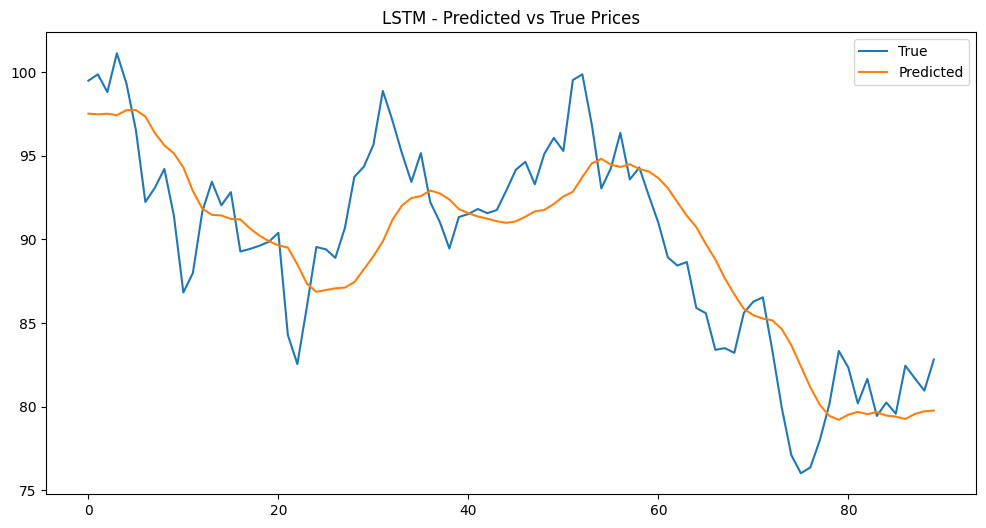

In [11]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='True')
plt.plot(lstm_preds_inv, label='Predicted')
plt.legend()
plt.title("LSTM - Predicted vs True Prices")
plt.show()

In [12]:
# Metrics
mae_lstm = mean_absolute_error(y_test_inv, lstm_preds_inv)
rmse_lstm = mean_squared_error(y_test_inv, lstm_preds_inv)**0.5
mape_lstm = mean_absolute_percentage_error(y_test_inv, lstm_preds_inv)
print("LSTM Performance:\nMAE:", mae_lstm, "RMSE:", rmse_lstm, "MAPE:", mape_lstm)

LSTM Performance:
MAE: 2.7194741956922743 RMSE: 3.3941324296964193 MAPE: 0.030508781152677106


# Forecast with LSTM

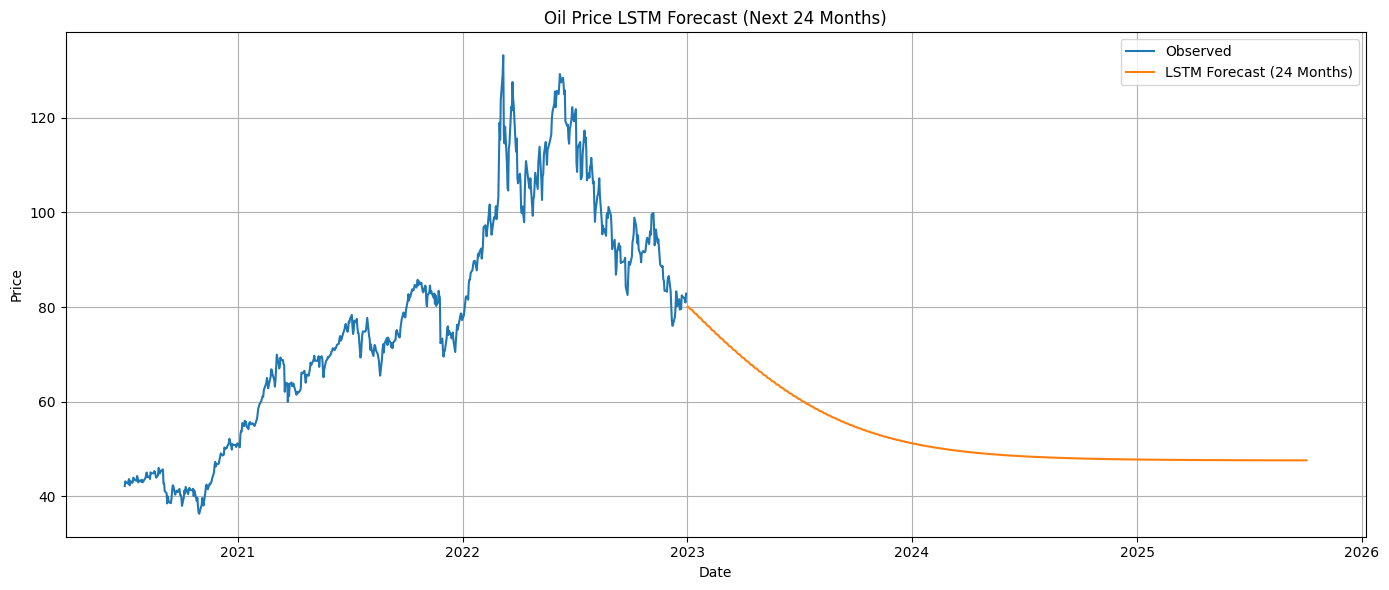

In [13]:
# --- LSTM FUTURE FORECAST (e.g., 24 months, 720 business days) ---
n_forecast = 24*30  # about 720 business days for 24 months
last_sequence = scaled[-seq_len:]
future_preds = []
current_seq = last_sequence.copy()

for _ in range(n_forecast):
    next_pred = lstm.predict(current_seq.reshape(1, seq_len, 1), verbose=0)
    future_preds.append(next_pred[0,0])
    current_seq = np.vstack([current_seq[1:], [[next_pred[0,0]]]])

# Inverse scale
future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='B')

plt.figure(figsize=(14,6))
plt.plot(df.index, df['Price'], label='Observed')
plt.plot(future_dates, future_preds_inv, label='LSTM Forecast (24 Months)')
plt.title('Oil Price LSTM Forecast (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
